In [10]:
%matplotlib inline


# Tutorial 01: Linear Models
In this tutorial you will set up your first linear model with BrainStat. 
To this end, we will first load some sample data from the MICS dataset. 


In [11]:
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.tutorial.utils import fetch_mics_data

# Load behavioral markers
thickness, demographics = fetch_mics_data()
pial_left, pial_right = fetch_template_surface("fsaverage5", join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")

Lets have a look at the cortical thickness data. To do this,
we will use the surface plotter included with BrainSpace.



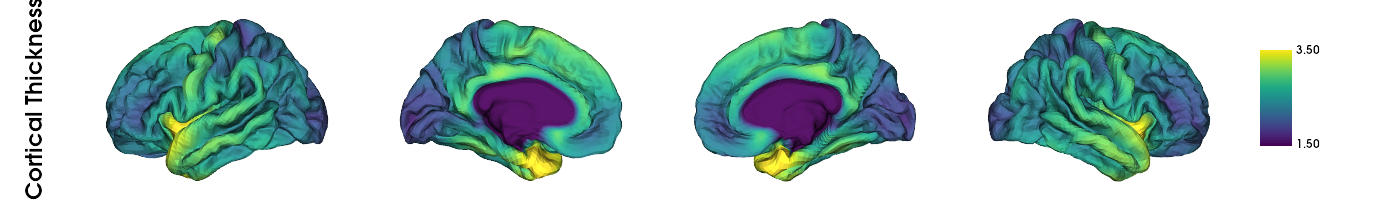

In [12]:
import numpy as np
from brainspace.plotting import plot_hemispheres

plot_hemispheres(
    pial_left,
    pial_right,
    np.mean(thickness, axis=0),
    color_bar=True,
    color_range=(1.5, 3.5),
    label_text=["Cortical Thickness"],
    cmap="viridis",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

Lets also have a look at what's inside the demographics data.



In [13]:
print(demographics)

    SUB_ID  VISIT  AGE_AT_SCAN SEX
0   031404      1           27   F
1   04a144      1           25   M
2   0b78f1      1           33   M
3   0d26b9      1           36   F
4   1988b8      1           31   M
..     ...    ...          ...  ..
77  f25714      1           30   F
78  f25714      2           33   F
79  f615a5      1           26   F
80  feac6b      1           26   F
81  feac6b      2           29   F

[82 rows x 4 columns]


Demographics contains four variables: a subject ID, a visit number (some
subjects visited multiple times), their age at the time of scanning and their
sex. Lets also print some summary statistics.



In [14]:
# Print demographics summary.
for i in range(1, 3):
    print(
        (
            f"Visit {i}, N={np.sum(demographics.VISIT==i)}, "
            f"{np.sum(demographics.SEX[demographics.VISIT == i] == 'F')} females, "
            f"mean subject age {np.mean(demographics.AGE_AT_SCAN[demographics.VISIT == i]):.2f}, "
            f"standard deviation of age: {np.std(demographics.AGE_AT_SCAN[demographics.VISIT==i]):.2f}."
        )
    )

Visit 1, N=70, 30 females, mean subject age 31.86, standard deviation of age: 8.82.
Visit 2, N=12, 5 females, mean subject age 32.75, standard deviation of age: 7.19.


Next, we will assess whether a subject's age is related to their cortical
thickness. To this end we can create a linear model with BrainStat. For our
first model, we will only consider the effect of age, i.e. we will disregard
the effect of sex and that some subjects visit twice. this end we can create a
linear model with BrainStat. First we declare the age variable as a
FixedEffect. The FixedEffect class can be created in two ways: either we
provide the data with pandas, as we do here, or we provide a numpy array and a
name for the fixed effect. Lets set up the model Y = intercept + B1 * age. Note
that BrainStat includes an intercept by default.



In [15]:
from brainstat.stats.terms import FixedEffect

term_age = FixedEffect(demographics.AGE_AT_SCAN)
model = term_age

As said before, if your data is not in a pandas DataFrame (e.g. numpy), you'll
have to provide the name of the effect as an additional parameter as follows:



In [16]:
term_age_2 = FixedEffect(demographics.AGE_AT_SCAN.to_numpy(), "AGE_AT_SCAN")

Lets have a look at one of these models. As you can see below, the model is
stored in a format closely resembling a pandas DataFrame. Note that an
intercept is automatically added to the model. This behavior can be disabled
in the FixedEffect call, but we recommend leaving it enabled. We can also
access the vectors related to each effect by their name i.e. model.intercept
and model.AGE_AT_SCAN will return the vectors of the intercept and age, respectively.



In [17]:
print(model)

    intercept  AGE_AT_SCAN
0           1           27
1           1           25
2           1           33
3           1           36
4           1           31
..        ...          ...
77          1           30
78          1           33
79          1           26
80          1           26
81          1           29

[82 rows x 2 columns]


Now, imagine we have some cortical marker (e.g. cortical thickness) for each
subject, and we want to evaluate whether this marker is different across the
the lifespan. To do this, we can use the model we defined before, and a
contrast in observations (here: age). Then we simply initialize an SLM model
and fit it to the cortical thickness data.



In [18]:
from brainstat.stats.SLM import SLM

contrast_age = demographics.AGE_AT_SCAN
slm_age = SLM(
    model,
    contrast_age,
    surf="fsaverage5",
    mask=mask,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
)
slm_age.fit(thickness)

Before we go any further, we can quickly assess the quality and
robustness of the fitted model. We can do this for every vertex/parcel
on the cortex (default), for one vertex (see example below for the 88th
vertex), or for a set of specific vertices. Our function slm.qc outputs
a histogram of the residuals and a qq plot of the residuals versus the
theoretical quantile values from a normal distribution. We can also map
vertexwise measures of skewness and kurtosis (characterizing the residuals
distribution) across the cortex.



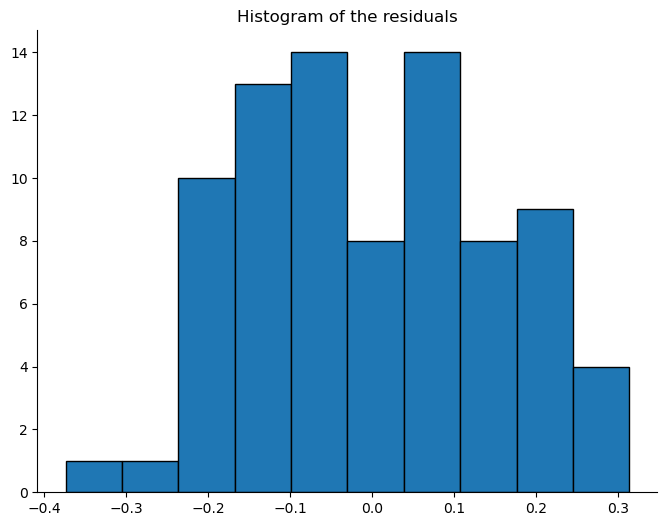

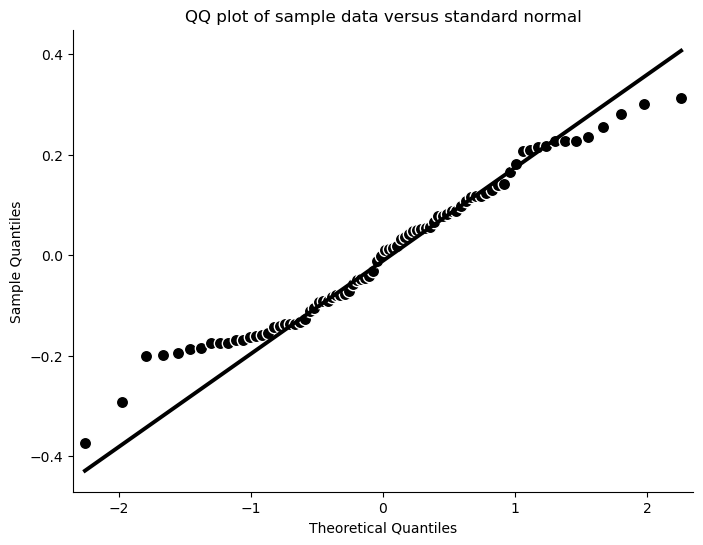

In [19]:
skwn, krts = slm_age.qc(thickness, v=87)

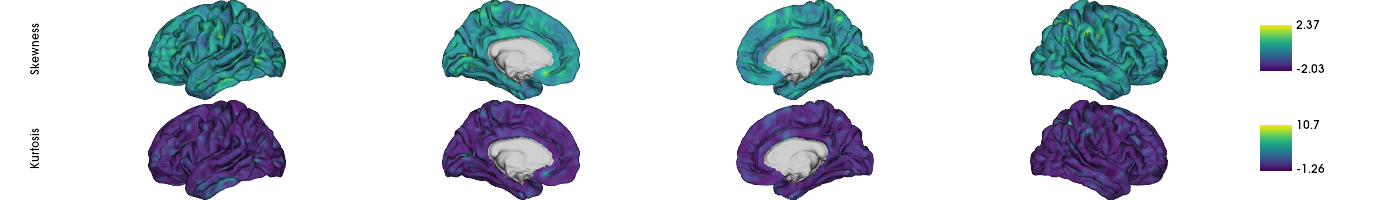

In [20]:
plot_hemispheres(
    pial_left,
    pial_right,
    np.vstack([skwn.T, krts.T]),
    cmap="viridis",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.8,
    nan_color=(0.7, 0.7, 0.7, 1),
    interactive=False,
    color_bar=True,
    label_text=["Skewness", "Kurtosis"],
    cb__labelTextProperty={"fontSize": 12},
)

The resulting model, slm_age, will contain the t-statistic map, p-values
derived with the requested corrections, and a myriad of other properties (see
the API for more details). Let's plot the t-values and p-values on the surface.



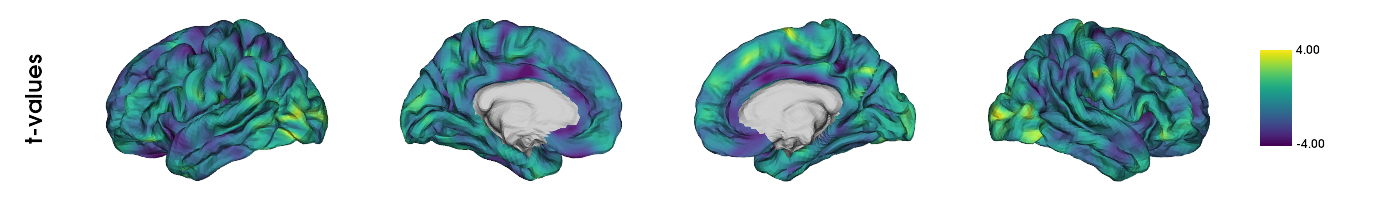

In [21]:
plot_hemispheres(
    pial_left,
    pial_right,
    slm_age.t,
    color_bar=True,
    color_range=(-4, 4),
    label_text=["t-values"],
    cmap="viridis",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

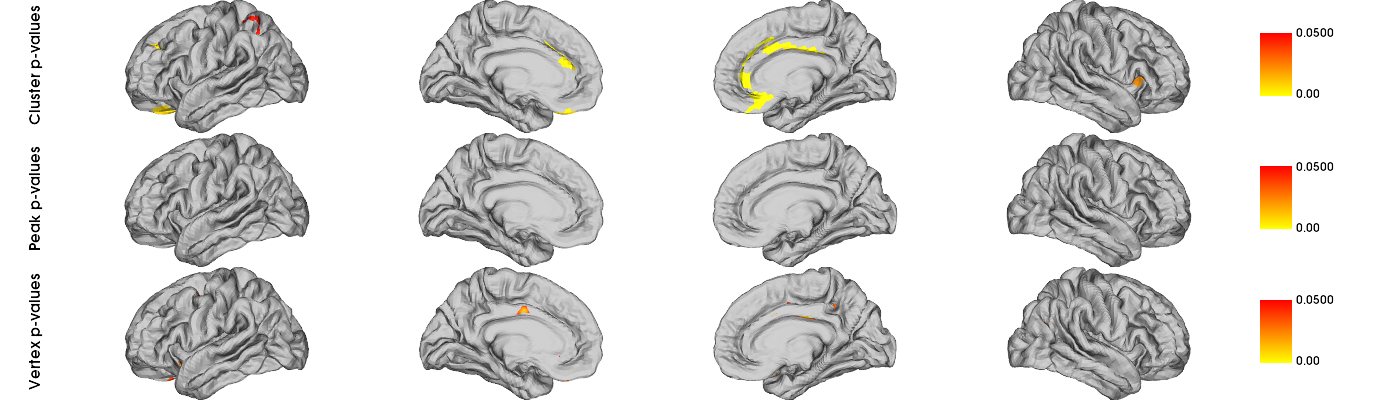

In [22]:
cp = [np.copy(slm_age.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

pp = [np.copy(slm_age.P["pval"]["P"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in pp]

qp = [np.copy(slm_age.Q)]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in qp]

vals = np.vstack([cp[0].T, pp[0].T, qp[0].T])

plot_hemispheres(
    pial_left,
    pial_right,
    vals,
    color_bar=True,
    color_range=(0, 0.05),
    label_text=["Cluster p-values", "Peak p-values", "Vertex p-values"],
    cmap="autumn_r",
    embed_nb=True,
    size=(1400, 400),
    zoom=1.8,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

Only clusters are significant, and not peaks. This suggests that the age
effect covers large regions, rather than local foci. Furthermore, at the
vertexwise level we only find a small group of significant vertices in the
left cingulate cortex. Lets have a closer look at the clusters and their
peaks. The data on clusters are stored in tables inside BrainStatModel.P.clus
and information on the peaks is stored in BrainStatModel.P.peak. If a
two-tailed test is run (BrainStat defaults to two-tailed), a table is returned
for each tail. The first table uses the contrast as provided, the second table
uses the inverse contrast. If a one-tailed test is performed, then only a
single table is returned. Lets print the first 15 rows of the inverted
contrast cluster table.




In [23]:
print(slm_age.P["clus"][1])

    clusid  nverts    resels         P
0        1   141.0  6.283315  0.000033
1        2    82.0  3.994467  0.001858
2        3    69.0  3.871711  0.002362
3        4    61.0  3.670485  0.003517
4        5    82.0  3.652319  0.003648
..     ...     ...       ...       ...
73      74     1.0  0.050811  1.000000
74      75     1.0  0.043958  1.000000
75      76     1.0  0.039022  1.000000
76      77     1.0  0.032002  1.000000
77      78     1.0  0.019503  1.000000

[78 rows x 4 columns]


Here, we see that cluster 1 contains 373 vertices. Clusters are sorted by
p-value; later clusters will generally be smaller and have higher p-values.
Lets now have a look at the peaks within these clusters.



In [24]:
print(slm_age.P["peak"][1])

            t  vertid  clusid          P               yeo7
0    5.695420   18720      11   0.001248  Ventral Attention
1    5.164823    5430      12   0.009035             Limbic
2    4.855500   16911       6   0.027242  Ventral Attention
3    4.833974   19629       2   0.029335     Frontoparietal
4    4.628306   12603      14   0.059519       Default mode
..        ...     ...     ...        ...                ...
109  2.403000    2276      62  23.356468  Ventral Attention
110  2.394788    2185      74  23.709038       Default mode
111  2.389922   14687      76  23.918494       Default mode
112  2.382012    6087      64  24.258914       Default mode
113  2.375295    3243      72  24.548027       Default mode

[114 rows x 5 columns]


Within cluster 1, we are able to detect several peaks. The peak with the
highest t-statistic (t=4.3972) occurs at vertex 19629, which is inside the
frontoparietal network as defined by the Yeo-7 networks. Note that the Yeo
network membership is only provided if the surface is specified as a template
name as we did here. For custom surfaces, or pre-loaded surfaces (as we will
use below) this column is omitted.



## Interaction effects models

Similarly to age, we can also test for the effect of sex on cortical thickness.



In [49]:
term_sex = FixedEffect(demographics.SEX)
model_sex = term_sex
contrast_sex = (demographics.SEX == "M").astype(int) - (demographics.SEX == "F").astype(
    int
)

In [50]:
demographics.SEX

0     F
1     M
2     M
3     F
4     M
     ..
77    F
78    F
79    F
80    F
81    F
Name: SEX, Length: 82, dtype: object

In [51]:
contrast_sex

0    -1
1     1
2     1
3    -1
4     1
     ..
77   -1
78   -1
79   -1
80   -1
81   -1
Name: SEX, Length: 82, dtype: int64

Next we will rerun the model and see if our results change.



In [26]:
slm_sex = SLM(
    model_sex,
    contrast_sex,
    surf=pial_combined,
    mask=mask,
    correction=["fdr", "rft"],
    two_tailed=False,
    cluster_threshold=0.01,
)
slm_sex.fit(thickness)

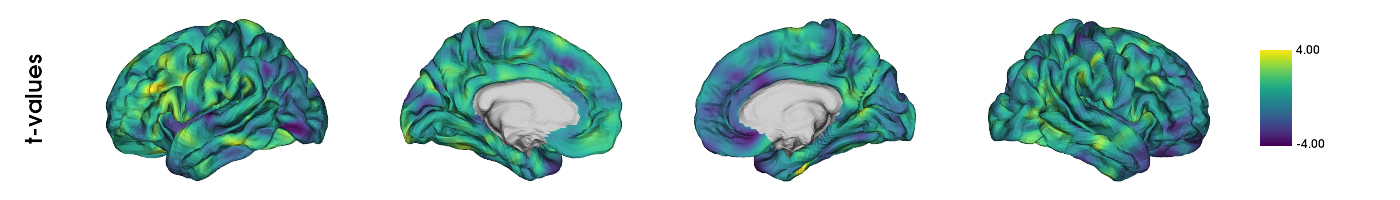

In [27]:
plot_hemispheres(
    pial_left,
    pial_right,
    slm_sex.t,
    color_bar=True,
    color_range=(-4, 4),
    label_text=["t-values"],
    cmap="viridis",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

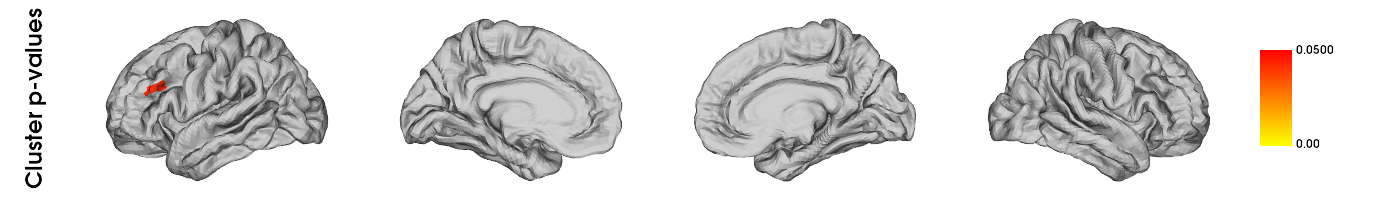

In [28]:
cp = [np.copy(slm_sex.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

plot_hemispheres(
    pial_left,
    pial_right,
    cp[0].T,
    color_bar=True,
    color_range=(0, 0.05),
    label_text=["Cluster p-values"],
    cmap="autumn_r",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

Here, we find few significant effects of sex on cortical thickness. However, as
we've already established, age has an effect on cortical thickness. So we may
want to correct for this effect before evaluating whether sex has an effect on
cortical thickenss. Lets make a new model that includes the effect of age.



In [29]:
model_sexage = term_age + term_sex

Next we will rerrun the model and see if our results change.



In [30]:
slm_sexage = SLM(
    model_sexage,
    contrast_sex,
    surf=pial_combined,
    mask=mask,
    correction=["fdr", "rft"],
    two_tailed=False,
    cluster_threshold=0.01,
)
slm_sexage.fit(thickness)

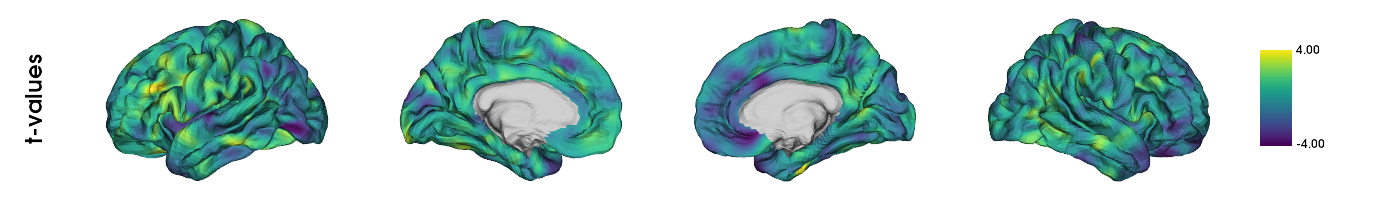

In [31]:
plot_hemispheres(
    pial_left,
    pial_right,
    slm_sexage.t,
    color_bar=True,
    color_range=(-4, 4),
    label_text=["t-values"],
    cmap="viridis",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

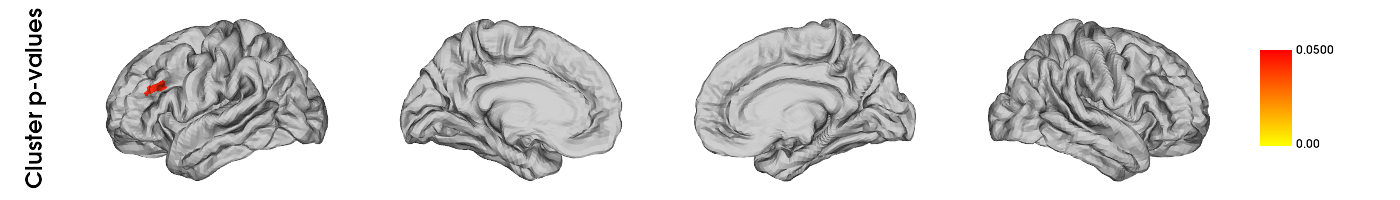

In [32]:
cp = [np.copy(slm_sexage.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

plot_hemispheres(
    pial_left,
    pial_right,
    cp[0].T,
    color_bar=True,
    color_range=(0, 0.05),
    label_text=["Cluster p-values"],
    cmap="autumn_r",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

After accounting for the effect of age, we still find only one significant
cluster of effect of sex on cortical thickness. However, it could be that age
affects men and women differently. To account for this, we could include an
interaction effect into the model. Lets run the model again with an
interaction effect.



In [33]:
# Effect of sex on cortical thickness.
model_sexage_int = term_age + term_sex + term_age * term_sex

slm_sexage_int = SLM(
    model_sexage_int,
    contrast_sex,
    surf=pial_combined,
    mask=mask,
    correction=["rft"],
    cluster_threshold=0.01,
)
slm_sexage_int.fit(thickness)

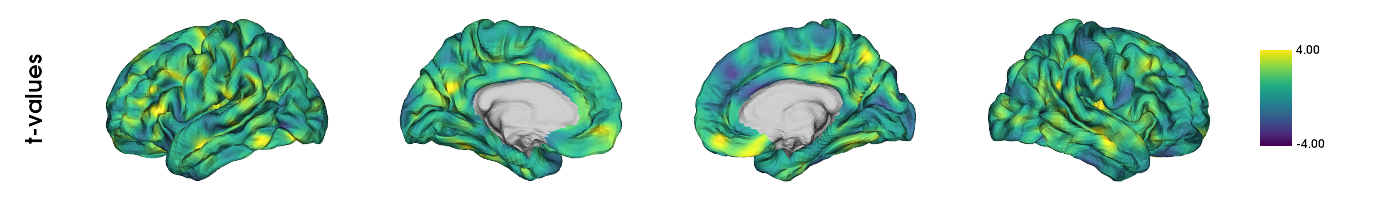

In [34]:
plot_hemispheres(
    pial_left,
    pial_right,
    slm_sexage_int.t,
    color_bar=True,
    color_range=(-4, 4),
    label_text=["t-values"],
    cmap="viridis",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

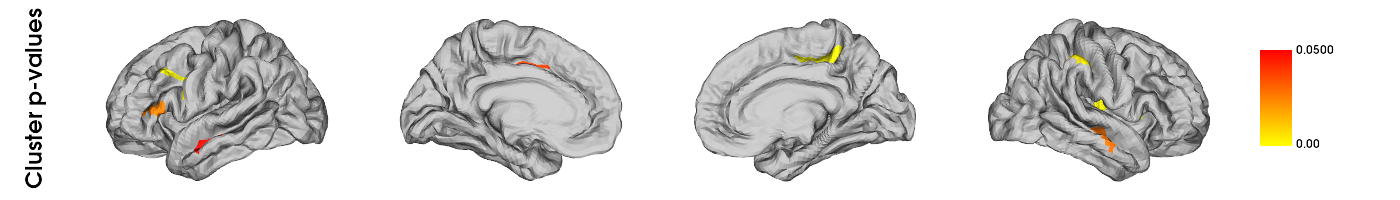

In [35]:
cp = [np.copy(slm_sexage_int.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

plot_hemispheres(
    pial_left,
    pial_right,
    cp[0].T,
    color_bar=True,
    color_range=(0, 0.05),
    label_text=["Cluster p-values"],
    cmap="autumn_r",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

After including the interaction effect, we no significant effects of
sex on cortical thickness in several clusters.

We could also look at whether the cortex of men and women changes
differently with age by comparing their interaction effects.



In [36]:
# Effect of age on cortical thickness for the healthy group.
contrast_sex_int = demographics.AGE_AT_SCAN * (
    demographics.SEX == "M"
) - demographics.AGE_AT_SCAN * (demographics.SEX == "F")

slm_sex_int = SLM(
    model_sexage_int,
    contrast_sex_int,
    surf=pial_combined,
    mask=mask,
    correction=["rft"],
    cluster_threshold=0.01,
)
slm_sex_int.fit(thickness)

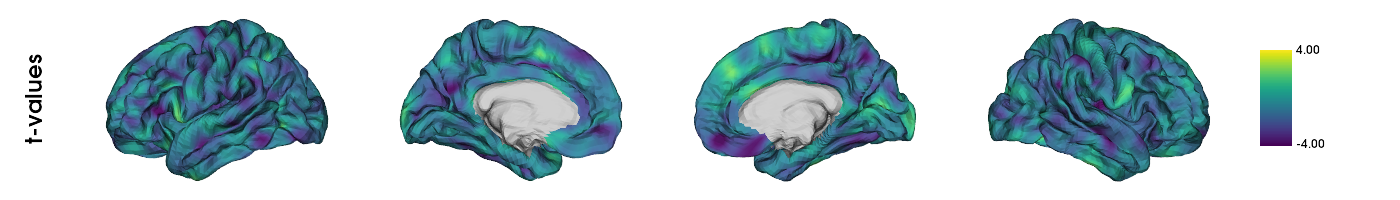

In [37]:
plot_hemispheres(
    pial_left,
    pial_right,
    slm_sex_int.t,
    color_bar=True,
    color_range=(-4, 4),
    label_text=["t-values"],
    cmap="viridis",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

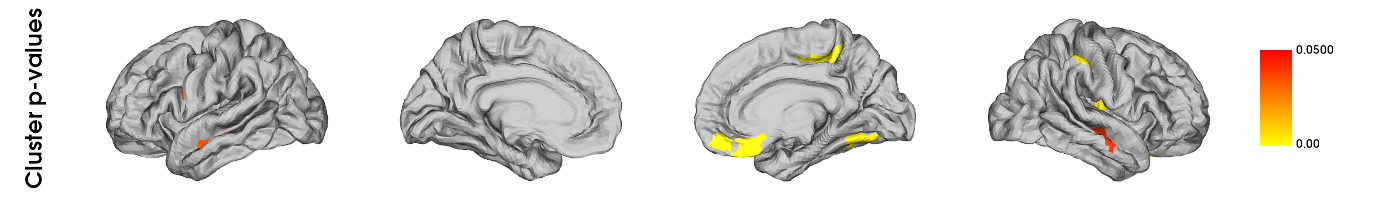

In [38]:
cp = [np.copy(slm_sex_int.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

plot_hemispheres(
    pial_left,
    pial_right,
    cp[0].T,
    color_bar=True,
    color_range=(0, 0.05),
    label_text=["Cluster p-values"],
    cmap="autumn_r",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

Indeed, it appears that the interaction effect between sex and age is quite
different across men and women, with stronger effects occuring in women.



## One-tailed Test



Imagine that, based on prior research, we hypothesize that men have higher
cortical thickness than women. In that case, we could run this same model with
a one-tailed test, rather than a two-tailed test. By default BrainStat uses a
two-tailed test. If you want to get a one-tailed test, simply specify it in
the SLM model initialization with 'two_tailed', false. Note that the
one-tailed test will test for the significance of positive t-values. If you
want to test for the significance of negative t-values, simply change the sign
of the contrast. We may hypothesize based on prior research that cortical
thickness decreases with age, so we could specify this as follows. Note the
minus in front of contrast_age to test for decreasing thickness with age.



In [39]:
from brainstat.stats.SLM import SLM

slm_onetailed = SLM(
    model_sexage_int,
    -contrast_age,
    surf=pial_combined,
    mask=mask,
    correction=["rft"],
    cluster_threshold=0.01,
    two_tailed=False,
)
slm_onetailed.fit(thickness)

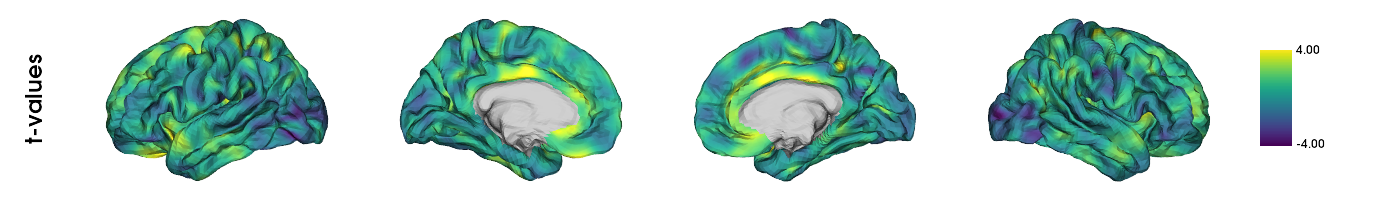

In [40]:
plot_hemispheres(
    pial_left,
    pial_right,
    slm_onetailed.t,
    color_bar=True,
    color_range=(-4, 4),
    label_text=["t-values"],
    cmap="viridis",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

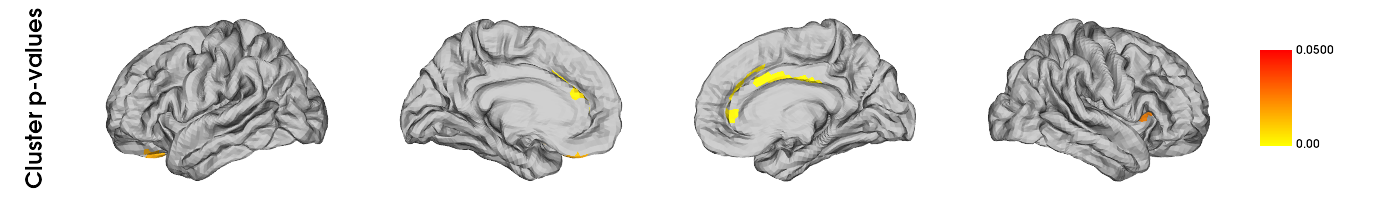

In [41]:
cp = [np.copy(slm_onetailed.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

plot_hemispheres(
    pial_left,
    pial_right,
    cp[0].T,
    color_bar=True,
    color_range=(0, 0.05),
    label_text=["Cluster p-values"],
    cmap="autumn_r",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

Notice the additional clusters that we find when using a one-tailed test.



## Mixed Effects Models



So far, we've considered multiple visits of the same subject as two separate,
independent measurements. Clearly, however, such measurements are not
independent of each other. To account for this, we could add subject ID as a
random effect. Lets do this and test the effect of age on cortical thickness
again.



In [42]:
from brainstat.stats.terms import MixedEffect

term_subject = MixedEffect(demographics.SUB_ID)

model_mixed = term_age + term_sex + term_age * term_sex + term_subject

slm_mixed = SLM(
    model_mixed,
    -contrast_age,
    surf=pial_combined,
    mask=mask,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
    two_tailed=False,
)
slm_mixed.fit(thickness)

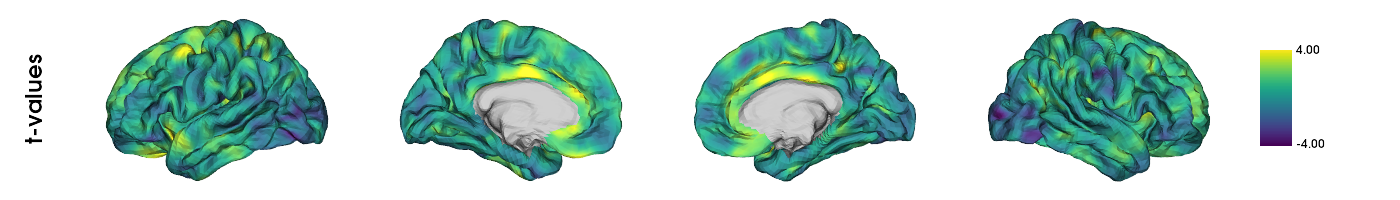

In [43]:
plot_hemispheres(
    pial_left,
    pial_right,
    slm_mixed.t,
    color_bar=True,
    color_range=(-4, 4),
    label_text=["t-values"],
    cmap="viridis",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

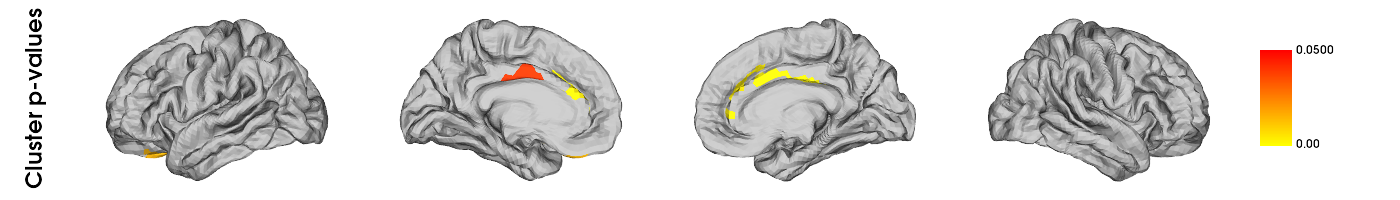

In [44]:
cp = [np.copy(slm_mixed.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

plot_hemispheres(
    pial_left,
    pial_right,
    cp[0].T,
    color_bar=True,
    color_range=(0, 0.05),
    label_text=["Cluster p-values"],
    cmap="autumn_r",
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
    interactive=False,
)

Compared to our first age model, we find fewer and smaller clusters,
indicating that by not accounting for the repeated measures structure of the
data we were overestimating the significance of effects.

That concludes the basic usage of the BrainStat for statistical models. In the
next tutorial we'll show you how to use the context decoding module.

